# Revise of the whole chapter + some minor experiments

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

## 1) Let's get the files into a data structure (fastai list "L")

glob approach:

In [3]:
from glob import glob

def glob_files():
    return L(glob(f"{path}/**/*.JPEG", recursive=True)).map(Path)

os.walk approach

In [4]:
import os

def oswalk_files():
    # Working on python list is much faster (~2x) than on fastai "L"
    files = []

    for root, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('.JPEG'):
                files.append(Path(os.path.join(root, filename)))

    return L(files)

In [5]:
files1 = glob_files()
files2 = oswalk_files()
assert files1 == files2

both work the same, let's see which one is faster

In [6]:
%timeit files = glob_files()

279 ms ± 54.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit files = oswalk_files()

The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
148 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


generally os.walk is faster

In [8]:
files = oswalk_files()
files[0]

Path('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_26879.JPEG')

## 2) Let's create a Dataset

In [9]:
lbls = files.map(Self.parent.name()).unique()
lbls

(#10) ['n02979186','n03028079','n03445777','n03394916','n03888257','n02102040','n03425413','n01440764','n03000684','n03417042']

In [10]:
v2i = lbls.val2idx()
v2i

{'n02979186': 0,
 'n03028079': 1,
 'n03445777': 2,
 'n03394916': 3,
 'n03888257': 4,
 'n02102040': 5,
 'n03425413': 6,
 'n01440764': 7,
 'n03000684': 8,
 'n03417042': 9}

In [11]:
class Dataset:
    def __init__(self, fns):
        self.fns = fns

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64, 64)).convert("RGB")
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float() / 255, tensor(y)

In [12]:
train_filt = L(o.parent.parent.name == "train" for o in files)
train, valid = files[train_filt], files[~train_filt]
len(train), len(valid)

(9469, 3925)

In [13]:
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[0]
x.shape, y

(torch.Size([64, 64, 3]), tensor(0))

<Axes: title={'center': 'n02979186'}>

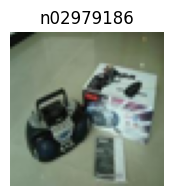

In [14]:
show_image(x, title=lbls[y])

In [15]:
def collate(idxs, ds):
    xb, yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb), torch.stack(yb)

In [16]:
x, y = collate((1, 2), train_ds)
x.shape, y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [17]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds, self.bs, self.shuffle, self.n_workers = ds, bs, shuffle, n_workers

    def __len__(self):
        return (len(self.ds)-1) // self.bs + 1

    def __iter__(self):
        idxs = L.range(len(self.ds))
        if self.shuffle:
            idxs = idxs.shuffle()

        chunks = [idxs[i:i+self.bs] for i in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

In [18]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb, yb = first(train_dl)
xb.shape, yb.shape, len(train_dl)

(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

For normalization, we'll need image statistics. Generally it's fine to calculate these on a single training mini-batch, since precision isn't needed here:

In [19]:
stats = (xb.mean((0,1,2)), xb.std((0,1,2)))
stats

(tensor([0.4514, 0.4481, 0.4151]), tensor([0.2799, 0.2774, 0.2964]))

In [20]:
class Normalize:
    def __init__(self, stats):
        self.stats = stats

    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)

        return (x - self.stats[0]) / self.stats[1]

In [21]:
norm = Normalize(stats)
def tfm_x(x):
    return norm(x).permute((0, 3, 1, 2))

In [22]:
t = tfm_x(x)
t.mean((0,2,3)), t.std((0,2,3))

(tensor([0.4749, 0.4953, 0.5945]), tensor([1.2601, 1.2617, 1.1865]))

## 3) Create Module and Parameter, which are needed to create a model

In [23]:
class Parameter(Tensor):
    def __new__(self, x):
        return Tensor._make_subclass(Parameter, x, True)

    def __init__(self, *args, **kwargs):
        self.requires_grad_()

In [24]:
Parameter(tensor(3.))

Parameter(3., requires_grad=True)

In [25]:
class Module:
    def __init__(self):
        self.hook, self.params, self.children, self._training = None, [], [], False

    def register_parameters(self, *ps):
        self.params += ps

    def register_modules(self, *ms):
        self.children += ms

    @property
    def training(self):
        return self._training

    @training.setter
    def training(self, v):
        self._training = v
        for m in self.children:
            m.training = v

    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self, k, v):
        super().__setattr__(k, v)
        if isinstance(v, Parameter):
            self.register_parameters(v)

        if isinstance(v, Module):
            self.register_modules(v)

    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None:
            self.hook(res, args)

        return res

    def cuda(self):
        for p in self.parameters():
            p.data = p.data.cuda()

Now, let's create a convolutional layer, and a linear layer

In [26]:
class ConvLayer(Module):
    def __init__(self, ni, nf, size=3, stride=1, bias=True, act=True, padding=None):
        super().__init__()
        self.padding = size // 2 if padding is None else padding
        self.w = Parameter(torch.zeros(nf, ni, size, size))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.stride, self.act, self.size = stride, act, size

        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)

    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, self.stride, padding=self.padding)
        if self.act: x = F.relu(x)
        return x

In [27]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [28]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

torch.Size([128, 4, 64, 64])

In [29]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf, ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)

    def forward(self, x):
        return x @ self.w.t() + self.b

In [30]:
l = Linear(4, 2)
r = l(torch.ones(3, 4))
r.shape

torch.Size([3, 2])

Let's check if including multiple layers doesn't break anything

In [31]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c, self.l = ConvLayer(2, 4), Linear(4, 2)

In [32]:
t = T()
# it should have 4 parameters
len(t.parameters())

4

In [33]:
t.cuda()
t.l.w.device

device(type='cuda', index=0)

## 4.) Create a simple CNN

In [34]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [35]:
class AdaptivePool(Module):
    def forward(self, x):
        return x.mean((2,3))

In [36]:
def simple_cnn():
    return Sequential(
        # we start with 64 x 64 image
        ConvLayer(3, 16 ,stride=2), # 32
        ConvLayer(16,32 ,stride=2), # 16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [37]:
m = simple_cnn()
len(m.parameters())

10

Now I can try adding a hook. Note that I've only left room for one hook in `Module`; I could make it a list, or use something like `Pipeline` to run a few as a single function:

In [38]:
# a hook that prints a shape of each layer activations
def shape_hook(out, args):
    print(out.shape)

# a hook that prints mean and standard deviation of activations
def print_stats(out, args):
    print(out.mean().item(), out.std().item())

def combined_hook(out, args):
    shape_hook(out, args)
    print_stats(out, args)
    print()

In [39]:
for i in range(4):
    m.children[i].hook = combined_hook

m.children[5].hook = shape_hook

In [40]:
r = m(xbt)

torch.Size([128, 16, 32, 32])
0.5272068977355957 0.8879507184028625

torch.Size([128, 32, 16, 16])
0.35814225673675537 0.6946260333061218

torch.Size([128, 64, 8, 8])
0.46036845445632935 0.7207672595977783

torch.Size([128, 128, 4, 4])
0.4420461058616638 0.7115216851234436

torch.Size([128, 10])


## 5) Loss function

Cross Entropy Loss - I devide the calculation into 2 steps:

1) logarithm of softmax

2) negative log likelyhood

1: for each input in the batch our model outputs probability of choosing each class, then we take exponents of them and normalise them so they sum up to 1 and finally take the logarithm of them.

2: then for each element of the batch we take the logarithm that corresponds to the correct class and change the sign of it. The final loss is average of these values for all items in the batch. If we want multiple classes, then we take weighted average of corresponding classes logs.

In [41]:
# negative log likelyhood:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

def log_softmax(x):
    return (x.exp() / x.exp().sum(-1, keepdim=True)).log()

In [42]:
sm = log_softmax(r)
sm[0][0]

Parameter(-2.7706, grad_fn=<AliasBackward0>)

In [43]:
loss = nll(sm, yb)
loss

Parameter(2.7154, grad_fn=<AliasBackward0>)

I can simplify the formula for softmax:

$$ \log \left( \frac{a}{b} \right) = \log{a} - \log{b} $$

In [44]:
def log_softmax(x):
    return x - (x.exp().sum(-1, keepdim=True)).log()

In [45]:
sm = log_softmax(r)
sm[0][0]

Parameter(-2.7706, grad_fn=<AliasBackward0>)

Another trick that I am going to use is called LogSumExp - it decreases the exponent of each term making the numbers smaller and thus more precise in floating point representation, $ a = \max(x_j) $

$$ \log \left( \sum_{j=1}^n e^{x_j} \right) = \log \left( e^a \sum_{j=1}^n e^{x_j - a} \right) = a + \log \left( \sum_{j=1}^n e^{x_j - a} \right) $$

In [46]:
def logsumexp(x):
    # 0 - values, 1 - indices
    a = x.max(-1)[0].unsqueeze(-1)
    return a + (x-a).exp().sum(-1, keepdim=True).log()

In [47]:
logsumexp(r).shape, r.shape

(torch.Size([128, 1]), torch.Size([128, 10]))

In [48]:
def log_softmax(x):
    return x - logsumexp(x)

In [49]:
sm = log_softmax(r)
sm[0][0]

Parameter(-2.7706, grad_fn=<AliasBackward0>)

or with pytorch logsumexp:

In [50]:
def log_softmax(x):
    return x - x.logsumexp(-1,keepdim=True)

In [51]:
sm = log_softmax(r)
sm[0][0]

Parameter(-2.7706, grad_fn=<AliasBackward0>)

In [52]:
def cross_entropy(preds, yb):
    return nll(log_softmax(preds), yb)

In [53]:
cross_entropy(r, yb)

Parameter(2.7154, grad_fn=<AliasBackward0>)

## 6) Time for learner

In [54]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params, self.lr, self.wd = params, lr, wd

    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + self.wd * p.data) * self.lr
            p.grad.data.zero_()

In [55]:
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls

dls = DataLoaders(train_dl, valid_dl)

In [56]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD, wd=0):
        self.model, self.dls, self.loss_func, self.lr, self.cbs, self.opt_func, self.wd = model, dls, loss_func, lr, cbs, opt_func, wd
        for cb in cbs:
            cb.learner = self

    def one_batch(self):
        self("before_batch")
        xb, yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()

        self("after_batch")

    def one_epoch(self, train):
        self.model.training = train
        self("before_epoch")
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()

        self("after_epoch")

    def fit(self, n_epochs):
        self("before_fit")
        self.opt = self.opt_func(self.model.parameters(), self.lr, self.wd)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException:
            pass

        self("after_fit")

    def __call__(self, name):
        for cb in self.cbs:
            getattr(cb, name, noop)()

## 7) Define callbacks

In [57]:
class Callback(GetAttr):
    _default = 'learner'

In [58]:
class SetupLearnerCB(Callback):
    # ensure that input and target are on the same device (preferably GPU - cuda), apply normalisation to input (tfm_x)
    def before_batch(self):
        xb, yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb), yb

    def before_fit(self):
        self.model.cuda()

In [59]:
class TrackResults(Callback):
    def before_epoch(self):
        self.accs, self.losses, self.ns = [], [], []

    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item() / n, sum(self.accs).item() / n)
        if not self.model.training:
            print()

    def after_batch(self):
        xb, yb = self.batch
        # preds have shape batch_size x classes
        # acc is the number of correct class assignemnts in the batch, it will be divided by the number of elements
        # in the training set to get the accuracy
        self.accs.append((self.preds.argmax(1)==yb).float().sum())
        n = len(xb)
        # self.loss is an average loss, by multiplying it by n I get total loss so then in after_epoch I can devide it
        # by the number if elements in the training set to get the average loss across the epoch
        self.losses.append(self.loss * n)
        self.ns.append(n)

Let's train simple_cnn

In [60]:
cbs = [SetupLearnerCB(), TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.118803381428873 0.2235716548737987


0 False 2.0520017665207004 0.2710828025477707



Now I will try to implement cbs without inheriting form Callback and GetAttr

In [61]:
class SetupLearnerCB:
    def before_batch(self):
        xb, yb = to_device(self.learner.batch)
        self.learner.batch = tfm_x(xb), yb

    def before_fit(self):
        self.learner.model.cuda()

In [62]:
class TrackResults:
    def before_epoch(self):
        self.accs, self.losses, self.ns = [], [], []

    def after_epoch(self):
        n = sum(self.ns)
        print(self.learner.epoch, self.learner.model.training, sum(self.losses).item() / n, sum(self.accs).item() / n)
        if not self.learner.model.training:
            print()

    def after_batch(self):
        xb, yb = self.learner.batch
        self.accs.append((self.learner.preds.argmax(1)==yb).float().sum())
        n = len(xb)
        self.losses.append(self.learner.loss * n)
        self.ns.append(n)

In [63]:
cbs = [SetupLearnerCB(), TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1629239162002323 0.21522864082796495


0 False 2.1202410927547772 0.23363057324840764



## 8) Last step - schedule the learning rate

In [64]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses, self.lrs = [], []
        self.learner.lr = 1e-6
        self.MA_loss = None

    def before_batch(self):
        if not self.model.training:
            return

        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training:
            return

        if self.opt.lr > 10 or torch.isnan(self.loss):
            raise CancelFitException

        if self.MA_loss == None:
            self.MA_loss = self.loss.item()
        else:
            self.MA_loss = 0.98*self.MA_loss + 0.02*self.loss.item()

        self.losses.append(self.MA_loss)
        self.lrs.append(self.opt.lr)

In [ ]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.4433094588261697 0.1275741894603443


0 False 2.23187201433121 0.13579617834394905



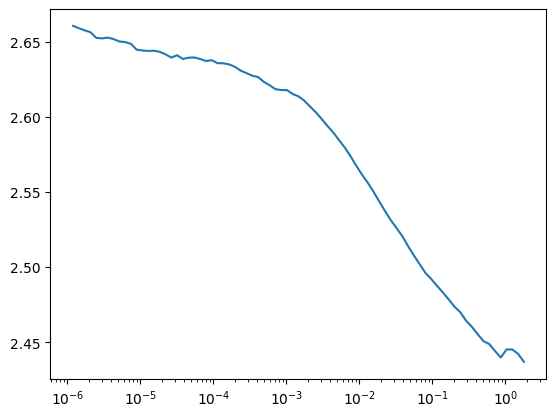

In [ ]:
plt.plot(lrfind.lrs[:-4], lrfind.losses[:-4])
plt.xscale('log')

In [65]:
class OneCycle(Callback):
    def __init__(self, base_lr):
        self.base_lr = base_lr

    def before_fit(self):
        self.lrs = []

    def before_batch(self):
        if not self.model.training:
            return

        n = len(self.dls.train)
        bn = self.epoch * n + self.num
        mn = self.n_epochs * n
        pct = bn / mn
        pct_start, div_start = 0.25, 10
        if pct < pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct - pct_start) / (1 - pct_start)
            lr = (1-pct)*self.base_lr

        self.opt.lr = lr
        self.lrs.append(lr)

In [ ]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [ ]:
learn.fit(8)

0 True 2.236722297761115 0.17763227373534693


0 False 2.1625686703821656 0.22038216560509555



1 True 2.055772042322315 0.27162319146689196


1 False 1.9432187997611465 0.32



2 True 1.9201215396953215 0.32569437110571337


2 False 1.93318259852707 0.3118471337579618



3 True 1.8063677361653818 0.36688140247122186


3 False 1.770872686106688 0.3994904458598726



4 True 1.722413682147006 0.40490020065476817


4 False 1.7123512141719746 0.4137579617834395



5 True 1.6554505161579893 0.43373112261062413


5 False 1.6553579070461784 0.4481528662420382



6 True 1.5863002173209948 0.4582321258844651


6 False 1.6197422372611465 0.4563057324840764



7 True 1.5400613391395608 0.48083218924912874


7 False 1.5985512042197452 0.46420382165605095



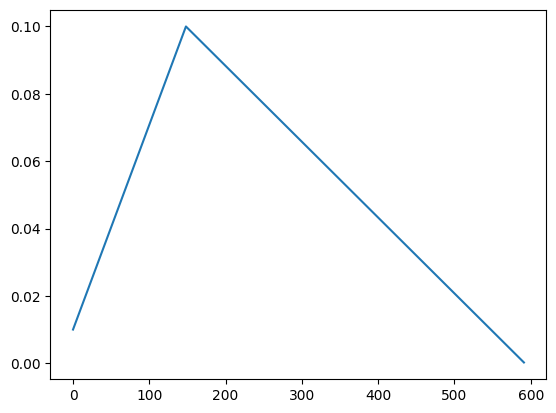

In [ ]:
plt.plot(onecyc.lrs);

Let's try using cosine annealing in OneCycle

In [66]:
import math

In [67]:
class CosOneCycle(Callback):
    def __init__(self, base_lr):
        self.base_lr = base_lr

    def before_fit(self):
        self.lrs = []

    def before_batch(self):
        if not self.model.training:
            return

        n = len(self.dls.train)
        bn = self.epoch * n + self.num
        mn = self.n_epochs * n
        pct = bn / mn
        pct_start, div_start = 0.25, 10
        min_lr = self.base_lr / div_start
        if pct < pct_start:
            pct /= pct_start
            lr = min_lr + 0.5 * (self.base_lr - min_lr) * (1 - math.cos(pct * math.pi))
        else:
            pct = (pct - pct_start) / (1 - pct_start)
            lr = self.base_lr - 0.5 * self.base_lr * (1 - math.cos(pct * math.pi))

        self.opt.lr = lr
        self.lrs.append(lr)

In [68]:
cosonecyc = CosOneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[cosonecyc])

In [69]:
learn.fit(8)

0 True 2.260117513398986 0.1702397296441018


0 False 2.147268859474522 0.22929936305732485



1 True 2.073359655520646 0.25124089132960187


1 False 1.9962983927149682 0.28203821656050954



2 True 1.9413847984211638 0.3247439011511247


2 False 1.9224248606687897 0.34038216560509554



3 True 1.8268669886603655 0.3660365402893653


3 False 1.756979374004777 0.3959235668789809



4 True 1.7101509077318091 0.40901890379131906


4 False 1.7056324641719744 0.41350318471337577



5 True 1.6191947696100433 0.44217974442919


5 False 1.63298728602707 0.44101910828025476



6 True 1.5631949073951843 0.47322842961241945


6 False 1.6074609375 0.45987261146496816



7 True 1.5395166959288205 0.4807265814763967


7 False 1.6021932225318471 0.45910828025477707



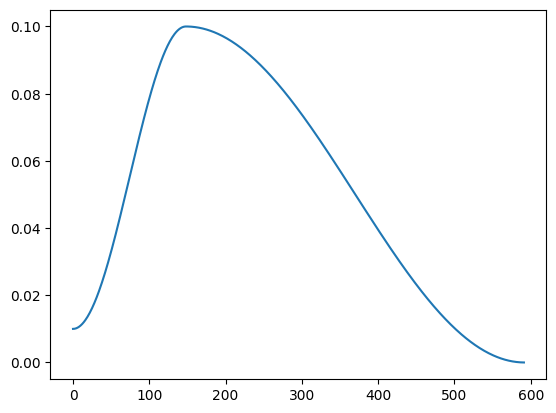

In [ ]:
plt.plot(cosonecyc.lrs);

# Further Research

## 1) Write ResNet18 from scratch (refer to Chapter 14 as needed), and train it with the Learner in this chapter.

For the reference I will put here copies of some of the classes defined before:

!!! I am not using the custom Parameter, because it causes ridiculous errors, I think that it is a bad idea to ever use something as a substitude of nn.Parameter

In [ ]:
class Module:
    def __init__(self):
        self.hook, self.params, self.children, self._training = None, [], [], False

    def register_parameters(self, *ps):
        self.params += ps

    def register_modules(self, *ms):
        self.children += ms

    @property
    def training(self):
        return self._training

    @training.setter
    def training(self, v):
        self._training = v
        for m in self.children:
            m.training = v

    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self, k, v):
        super().__setattr__(k, v)
        if isinstance(v, nn.Parameter):
            self.register_parameters(v)
        elif isinstance(v, Module):
            self.register_modules(v)


    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None:
            self.hook(res, args)

        return res

    def cuda(self):
        for p in self.parameters():
            p.data = p.data.cuda()

In [ ]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

a little different Linear layer and ConvLayer

In [ ]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = nn.Parameter(torch.zeros(nf, ni))
        self.b = nn.Parameter(torch.zeros(nf))
        # Xavier initialisation, because this layer used only as the final one, and a softmax function is applied in the loss.
        nn.init.xavier_normal_(self.w)

    def forward(self, x):
        return x @ self.w.t() + self.b

In [ ]:
class ConvLayer(Module):
    def __init__(self, ni, nf, size=3, stride=1, bias=True, padding=None):
        super().__init__()
        self.padding = size // 2 if padding is None else padding
        self.w = nn.Parameter(torch.zeros(nf, ni, size, size))
        self.b = nn.Parameter(torch.zeros(nf)) if bias else None
        self.stride, self.size = stride, size
        nn.init.kaiming_normal_(self.w)

    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, self.stride, padding=self.padding)
        return x

ResNet18 starts here:

## 2) Implement a batchnorm layer from scratch and use it in your resnet18

BatchNorm equation:

$$ y = \frac{x - mean}{ \sqrt{var + ϵ}} * γ + β $$

In [ ]:
class BatchNorm(Module):
    def __init__(self, nf, zero_init=False, eps=1e-5, momentum=0.1):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(nf)) if zero_init == False else nn.Parameter(torch.zeros(nf))
        self.beta = nn.Parameter(torch.zeros(nf))
        self.eps, self.momentum = eps, momentum
        self.running_mean, self.running_var = torch.zeros(nf).cuda()[None, :, None, None], torch.zeros(nf).cuda()[None, :, None, None]

    def forward(self, x):
        if self.training:
            mean = x.mean([0, 2, 3], keepdim=True)
            var = x.var([0, 2, 3], keepdim=True, unbiased=False)
            x = (x - mean) / (var + self.eps).sqrt()
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var
            x = (x - mean) / (var + self.eps).sqrt()

        return self.gamma.unsqueeze(0).unsqueeze(2).unsqueeze(3) * x + self.beta.unsqueeze(0).unsqueeze(2).unsqueeze(3)

custom MaxPool and ReLU are needed, because of custom Module

In [ ]:
class MaxPool(Module):
    def __init__(self, ks, stride, pad):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=ks, stride=stride, padding=pad)

    def forward(self, x):
        return self.pool(x)

In [ ]:
class ReLU(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.relu(x)

In [ ]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()

        self.convs = Sequential(
            ConvLayer(ni, nf, stride=stride),
            BatchNorm(nf),
            ReLU(),

            ConvLayer(nf, nf),
            BatchNorm(nf, zero_init=True)
        )

        self.Iconv = noop if ni == nf else ConvLayer(ni, nf, size=1)
        self.pool = noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        # pool goes before Iconv (Identity conv) as it reduces the amount of computations
        return F.relu(self.convs(x) + self.Iconv(self.pool(x)))

In [ ]:
class ResNet18(Module):
    def __init__(self, n_out):
        super().__init__()

        self.stem = Sequential(
            ConvLayer(3, 16, stride=2),
            BatchNorm(16),
            ReLU(),

            ConvLayer(16, 32),
            BatchNorm(32),
            ReLU(),

            ConvLayer(32, 64),
            BatchNorm(64),
            ReLU(),
            MaxPool(ks=3, stride=2, pad=1)
        )

        self.blocks = Sequential(
            self._make_layer(64, 64, 1),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
            self._make_layer(256, 512)
        )

        self.linear = Linear(512, n_out)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        return self.linear(x)

    def _make_layer(self, ni, nf, stride=2):
        return Sequential(
            ResBlock(ni, nf, stride=stride),
            ResBlock(nf, nf, stride=1)
        )

In [ ]:
lrfind = LRFinder()
learn = Learner(ResNet18(10), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.7527152748442285 0.12366670186925757


0 False 4.572309414808918 0.09095541401273885



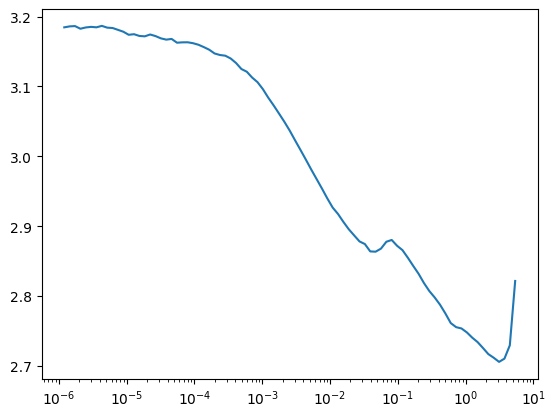

In [ ]:
plt.plot(lrfind.lrs[:-3], lrfind.losses[:-3])
plt.xscale('log')

In [ ]:
cosonecyc = CosOneCycle(1)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=1, cbs=cbs+[cosonecyc])

In [ ]:
learn.fit(8)

0 True 2.2213982386603655 0.24933995142042453


0 False 1.9504036873009554 0.31414012738853503



1 True 1.9564138983129158 0.3114373217868835


1 False 1.7336710041799364 0.37528662420382164



2 True 1.5758437070968423 0.46076671243003486


2 False 1.6423940087579618 0.46929936305732484



3 True 1.210380377745802 0.5978456014362658


3 False 1.5495609822850318 0.5182165605095541



4 True 0.9259490467248389 0.6924701658042032


4 False 1.160107359673567 0.618343949044586



5 True 0.6464828280111417 0.7945928820361179


5 False 0.9690447103901274 0.6912101910828026



6 True 0.34658805419328864 0.8966099904953004


6 False 0.9051278861464969 0.7228025477707006



7 True 0.18617876838235295 0.9553279121343331


7 False 0.8959574666600318 0.7243312101910828



I am overfitting, I will try to train with a bigger batch size

In [ ]:
train_dl = DataLoader(train_ds, bs=512, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=512, shuffle=False, n_workers=n_workers)
dls = DataLoaders(train_dl, valid_dl)

lrfind = LRFinder()
learn = Learner(ResNet18(10), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(10)

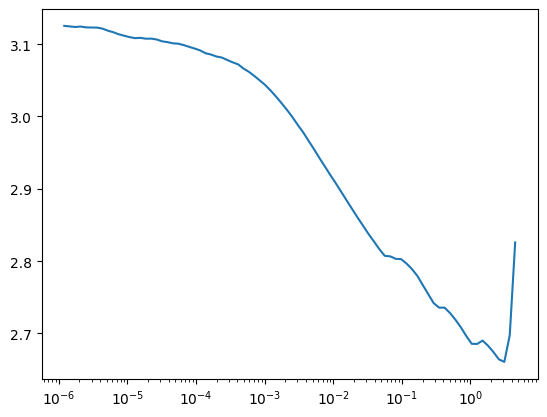

In [ ]:
plt.plot(lrfind.lrs[:-3], lrfind.losses[:-3])
plt.xscale('log')

Learning rate finder graph is smoother, I will train for more epochs as there will be less batches in each single one

In [ ]:
cosonecyc = CosOneCycle(1)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=1, cbs=cbs+[cosonecyc])
learn.fit(16)

0 True 2.6162547688509874 0.20825852782764812


0 False 2.4508874900477706 0.1780891719745223



1 True 2.2162300582822896 0.2137501320097159


1 False 2.08343550955414 0.2647133757961783



2 True 2.0705012326407224 0.25673249551166966


2 False 2.077773935111465 0.20560509554140127



3 True 2.1619977855370154 0.23286513887422114


3 False 2.0234608877388536 0.26343949044585985



4 True 1.9840472446272046 0.2913718449677896


4 False 1.9567779657643312 0.31719745222929935



5 True 1.7857901029015735 0.37723096419896507


5 False 1.8520120919585987 0.34573248407643314



6 True 1.624351296005386 0.4456648009293484


6 False 5.4713992834394904 0.23821656050955414



7 True 1.4461943867818672 0.507234132432147


7 False 1.7407849820859873 0.42929936305732486



8 True 1.267435595759848 0.5719716971169078


8 False 1.4348315585191083 0.5406369426751593



9 True 1.0629301660352202 0.6482205090294646


9 False 1.3811017117834394 0.5556687898089172



10 True 0.8867973370340057 0.7135917203506178


10 False 1.2371352507961784 0.5987261146496815



11 True 0.7103239642187665 0.7741049741260957


11 False 1.0143629329219745 0.6713375796178344



12 True 0.5263620824367673 0.8441229274474601


12 False 0.9868284111265924 0.6794904458598726



13 True 0.3903763215410154 0.8966099904953004


13 False 0.9536218650477707 0.6914649681528663



14 True 0.3092309547107667 0.9299820466786356


14 False 0.9569592829418789 0.6927388535031848



15 True 0.27826619367310435 0.9395923539972542


15 False 0.9606411723726115 0.6909554140127389



It didn't help at all, I will try to apply regularisation and data augmentation later on

Let's replace ResBlock with a bottleneck version of it and see if it improves the performance

In [ ]:
class ResBottleNeck(Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()

        self.convs = Sequential(
            ConvLayer(ni, nf//4, size=1),
            BatchNorm(nf//4),
            ReLU(),

            ConvLayer(nf//4, nf//4, size=1 ,stride=stride),
            BatchNorm(nf//4),
            ReLU(),

            ConvLayer(nf//4, nf, size=1),
            BatchNorm(nf, zero_init=True)
        )

        self.Iconv = noop if ni == nf else ConvLayer(ni, nf, size=1)
        self.pool = noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        # pool goes before Iconv (Identity conv) as it reduces computations
        return F.relu(self.convs(x) + self.Iconv(self.pool(x)))

In [ ]:
class BNResNet18(Module):
    def __init__(self, n_out):
        super().__init__()

        self.stem = Sequential(
            ConvLayer(3, 16, stride=2),
            BatchNorm(16),
            ReLU(),

            ConvLayer(16, 32),
            BatchNorm(32),
            ReLU(),

            ConvLayer(32, 64),
            BatchNorm(64),
            ReLU(),
            MaxPool(ks=3, stride=2, pad=1)
        )

        self.blocks = Sequential(
            self._make_layer(64, 256, 1),
            self._make_layer(256, 512),
            self._make_layer(512, 1024),
            self._make_layer(1024, 2048)
        )

        self.linear = Linear(2048, n_out)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        return self.linear(x)

    def _make_layer(self, ni, nf, stride=2):
        return Sequential(
            ResBottleNeck(ni, nf, stride=stride),
            ResBottleNeck(nf, nf, stride=1)
        )

I have to reduce batch size, because I am running out of memory

In [ ]:
train_dl = DataLoader(train_ds, bs=16, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=16, shuffle=False, n_workers=n_workers)
dls = DataLoaders(train_dl, valid_dl)

In [ ]:
lrfind = LRFinder()
learn = Learner(BNResNet18(10), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

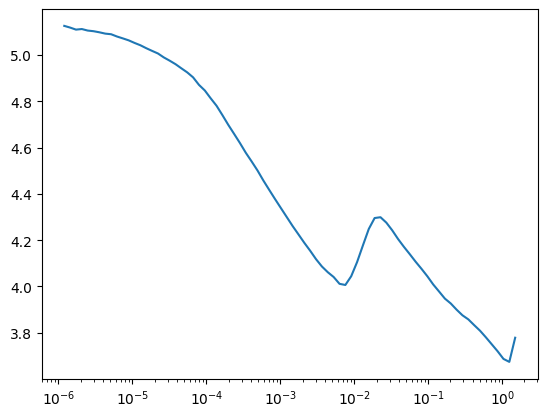

In [ ]:
plt.plot(lrfind.lrs[:-3], lrfind.losses[:-3])
plt.xscale('log')

Unfortunately even after reducing batch size - I can't train it because I am still running out of memory, probably all that custom stuff is making the memory usage skyrocket.

In [ ]:
cosonecyc = CosOneCycle(1)
learn = Learner(BNResNet18(10), dls, cross_entropy, lr=1, cbs=cbs+[cosonecyc])

In [ ]:
learn.fit(8)

## 3) Data Augmentation

In [ ]:
from torchvision.transforms import v2

In [ ]:
class BatchAug:
    def __init__(self, transforms=None):
        self.transforms = transforms

    def before_batch(self):
        if not self.learner.model.training:
            return

        x, y = self.learner.batch
        if self.transforms:
            x = self.transforms(x)

        self.learner.batch = (x, y)

After quite a few hours of experiments, this simple augmentation seems to work the best, I think that this is because I am using small dataset with small images and I am classifying only 10 classes, using more complicated augmentations would make sense for more difficult problems with bigger images.

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=64, scale=(0.8, 1)),
    v2.RandomHorizontalFlip(),
])

In [ ]:
class DatasetAug:
    def __init__(self, fns):
        self.fns = fns

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((128, 128)).convert("RGB")
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float() / 255, tensor(y)

In [ ]:
train_ds = DatasetAug(train)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
dls = DataLoaders(train_dl, valid_dl)

In [ ]:
augment = BatchAug(transforms)

In [ ]:
lrfind = LRFinder()
learn = Learner(ResNet18(10), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind, augment])
learn.fit(3)

0 True 3.079969010719189 0.12894709050586123


0 False 2.2657810011942674 0.16713375796178345



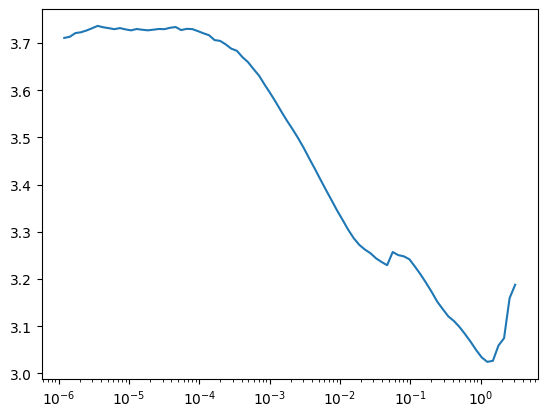

In [ ]:
plt.plot(lrfind.lrs[:-3], lrfind.losses[:-3])
plt.xscale('log')

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment])
learn.fit(8)

0 True 2.4689038738251137 0.20297813919104446


0 False 2.0624015973328027 0.24229299363057324



1 True 2.0878006933810327 0.25166332242053013


1 False 3.273351164410828 0.17579617834394903



2 True 1.803367196575668 0.3828281761537649


2 False 1.8120226662022294 0.37630573248407645



3 True 1.5402060341641144 0.4852677157038758


3 False 1.4403266819267515 0.5194904458598726



4 True 1.239768421955856 0.5940437216179111


4 False 1.5739803941082802 0.5011464968152867



5 True 0.9861723947882565 0.6724046889851093


5 False 1.0710750895700636 0.6568152866242039



6 True 0.8112429168536804 0.7353469215334248


6 False 0.8709334569068471 0.7253503184713376



7 True 0.7039228337205619 0.7699862709895449


7 False 0.8566420556329618 0.732484076433121



I am not overfitting anymore and the score on validation set is slightly better

## 4) Write a Mixup callback for use in this chapter.

In [ ]:
import torch.distributions as dist

In [ ]:
class Mixup:
    def __init__(self, alpha):
        self.dist = dist.Beta(alpha, alpha)

    def before_fit(self):
        # store the deafult loss function
        self._valid_loss_func = self.learner.loss_func

    def before_epoch(self):
        # swap between deafult loss (validation), and a loss adjusted to mixup (training)
        if self.learner.model.training:
            self.learner.loss_func = self._train_loss_func
        else:
            self.learner.loss_func = self._valid_loss_func

    def before_batch(self):
        # apply mixup only for training
        if not self.learner.model.training:
            return

        x1, y1 = self.learner.batch
        # The -1 in view() is a special value that PyTorch infers from the size of the tensor and the rest of the dimensions specified.
        lam = self.dist.sample((x1.shape[0],)).to(x1.device)
        idxs = torch.randperm(x1.shape[0])
        x2, y2 = x1[idxs], y1[idxs]
        new_x = lam[:, None, None, None] * x1 + (1-lam[:, None, None, None]) * x2
        new_y = torch.stack((y1, y2, lam))
        self.learner.batch = (new_x, new_y)

    def _train_loss_func(self, x, target):
        t1, t2, lam = target
        # t1 and t2 must be of type int, so that I can use them for indexing
        t1, t2 = t1.to(torch.int), t2.to(torch.int)
        x = x - x.logsumexp(-1, keepdim=True)
        idx = range(t1.shape[0])
        selected_values = lam * x[idx, t1] + (1-lam) * x[idx, t2]
        return -selected_values.mean()


I need to tweak accuracy calculation in TrackResults callback

In [ ]:
class TrackResultsMixup:
    def before_epoch(self):
        self.accs, self.losses, self.ns = [], [], []

    def after_epoch(self):
        n = sum(self.ns)
        print(self.learner.epoch, self.learner.model.training, sum(self.losses).item() / n, sum(self.accs).item() / n)
        if not self.learner.model.training:
            print()

    def after_batch(self):
        xb, yb = self.learner.batch
        # this if statement is added
        if self.learner.model.training:
            y1, y2, lam = yb
            lam = lam.view(-1)
            yb = torch.where(lam >= 0.5, y1, y2)

        self.accs.append((self.learner.preds.argmax(1)==yb).float().sum())
        n = len(xb)
        self.losses.append(self.learner.loss * n)
        self.ns.append(n)

cbs_mixup = [SetupLearnerCB(), TrackResultsMixup()]

In [ ]:
cosonecyc = CosOneCycle(3)
mixup = Mixup(0.4)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs_mixup+[cosonecyc, mixup, augment])
learn.fit(8)

0 True 2.481149218832506 0.18111733023550533


0 False 2.3079998507165604 0.16713375796178345



1 True 2.2351847971010668 0.19938747491815398


1 False 2.105127139729299 0.25681528662420383



2 True 2.0490647111627416 0.30235505333192525


2 False 1.8072141222133757 0.38089171974522296



3 True 1.899975825720773 0.38272256838103286


3 False 2.5672529359076433 0.25554140127388536



4 True 1.739654151045517 0.4495722885204351


4 False 1.6112905553343948 0.4698089171974522



5 True 1.562506291088024 0.5370155243425916


5 False 1.2874420282643313 0.5793630573248407



6 True 1.4382017141461612 0.5904530573450206


6 False 1.1317803294187898 0.6356687898089172



7 True 1.3647290253062625 0.6188615482099482


7 False 1.0857946855095542 0.6545222929936306



Models with Mixup need more epochs to learn, let's see how things will be going for 20 epochs

In [ ]:
cosonecyc = CosOneCycle(3)
mixup = Mixup(0.4)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs_mixup+[cosonecyc, mixup, augment])
learn.fit(20)

0 True 2.422672833720562 0.19980990600908227


0 False 2.0209525527468153 0.28815286624203823



1 True 2.053453002891013 0.29443447037701975


1 False 1.956237186504777 0.3110828025477707



2 True 1.9676153352386736 0.34385890801562996


2 False 2.062929065485669 0.28229299363057325



3 True 1.9003355521966416 0.3911711901995987


3 False 2.262624402866242 0.30394904458598726



4 True 1.8091970756547682 0.43415355370155245


4 False 1.8326072352707006 0.37605095541401273



5 True 1.6719477084763439 0.5039602914774527


5 False 1.9608175756369426 0.4132484076433121



6 True 1.5554112845205408 0.5512725736614215


6 False 1.4415371218152866 0.5164331210191083



7 True 1.4576466421678635 0.591086703981413


7 False 1.6059270501592358 0.4726114649681529



8 True 1.3991823235690146 0.6179110782553596


8 False 1.0434096959593948 0.6578343949044586



9 True 1.338187646860809 0.6396662794381667


9 False 1.026902741839172 0.6777070063694267



10 True 1.283296563127046 0.6671243003485057


10 False 1.2562697800557325 0.5964331210191083



11 True 1.2206522806328546 0.6946879290315767


11 False 1.0412938520103503 0.6728662420382165



12 True 1.1689450031022284 0.7121132115323687


12 False 0.9203603951035032 0.704203821656051



13 True 1.1171969881983315 0.7331291583060513


13 False 0.8641484623805733 0.7296815286624204



14 True 1.085981434483578 0.7522441651705566


14 False 0.855780192575637 0.729171974522293



15 True 1.067053097607984 0.7567852993980357


15 False 0.7600490769307325 0.7638216560509554



16 True 1.0205675262699334 0.7827648114901257


16 False 0.7257851064888535 0.7727388535031847



17 True 0.9921988445849614 0.7906853944450312


17 False 0.7054249601910828 0.7793630573248408



18 True 0.9684084248600697 0.8043087971274686


18 False 0.7060507066082803 0.778343949044586



19 True 0.9807045111020171 0.7963882141725631


19 False 0.7017707503980892 0.7768152866242038



To make a fair comparison I have to train my ResNet18 without Mixup for 20 epochs

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment])
learn.fit(20)

0 True 2.3730648200707574 0.2145949941915725


0 False 2.182297969745223 0.24178343949044587



1 True 1.9000311047893126 0.33762804942443764


1 False 3.083238455414013 0.1961783439490446



2 True 1.7103798620828492 0.42306473756468477


2 False 2.5072108877388537 0.30853503184713377



3 True 1.5765786299371634 0.47259478297602703


3 False 2.470177896098726 0.3559235668789809



4 True 1.395299381534481 0.5449361072974971


4 False 2.105170680732484 0.4313375796178344



5 True 1.1739072276969584 0.624141936846552


5 False 1.470310011942675 0.5763057324840765



6 True 1.042767744581001 0.6659626148484529


6 False 1.4917785877786625 0.5495541401273886



7 True 0.9667360267715703 0.690886049213222


7 False 1.3427753035429937 0.586751592356688



8 True 0.8427240885554177 0.7290104551695005


8 False 1.316000696656051 0.590828025477707



9 True 0.7690218265689355 0.747069384306685


9 False 0.9848686305732484 0.6899363057324841



10 True 0.6834617402840849 0.7828704192628577


10 False 1.0389078672372611 0.6850955414012739



11 True 0.6110497701380821 0.797655507445348


11 False 0.9750238853503185 0.70828025477707



12 True 0.5253563849799345 0.828070545992185


12 False 1.4532661972531846 0.6147770700636943



13 True 0.4622194896669395 0.851093040447777


13 False 0.8180047646297771 0.7559235668789809



14 True 0.3799298151781471 0.87569965149435


14 False 0.7670018287221337 0.7709554140127388



15 True 0.31952381929685025 0.898827753722674


15 False 0.77539162022293 0.7780891719745223



16 True 0.2641169694777036 0.9156193895870736


16 False 0.7701959967157643 0.7844585987261147



17 True 0.22175634079793272 0.9287147534058506


17 False 0.8107683121019108 0.7811464968152866



18 True 0.20075707572077306 0.9360016897243637


18 False 0.7855244202826434 0.7847133757961784



19 True 0.1921488046520224 0.9394867462245221


19 False 0.7962841485867834 0.7839490445859872



Even though Mixup is known for making a difference in long trainings e.g. 80+ epochs, my ResNet18 with Mixup got simillar accuracy on validation set, as the version without Mixup, but with much less overfitting and therefore a better generalisation. Now let's see if weight decay will help my ResNet18 without Mixup generalise better on 20 epoch training, as there seem to be a place for improvement.

## 5) Weight Decay regularisation

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment], wd=0.002)
learn.fit(8)

0 True 2.4600311707941707 0.196536065054388


0 False 2.1787308419585987 0.20331210191082802



1 True 2.06659457011036 0.25937268982997147


1 False 2.237950089570064 0.2621656050955414



2 True 1.9402474522124828 0.3281233498785511


2 False 2.1265358777866243 0.3319745222929936



3 True 1.7187836212245222 0.4084908649276587


3 False 1.981944416799363 0.34853503184713375



4 True 1.5155299117515049 0.48231069806737775


4 False 1.541201731687898 0.4794904458598726



5 True 1.2610584951552435 0.5815820044355264


5 False 1.3275413017515925 0.5615286624203821



6 True 0.998838108234766 0.6759953532579998


6 False 0.9788846039012739 0.6886624203821656



7 True 0.851550691318381 0.7242581053965572


7 False 0.9105302050159235 0.7118471337579618



After some experiments, it turns out that wd = 0.002 seems quite good for 8 epochs.
I will calculate wd for 20 epochs with the following formula:
$$ w = w_{norm} * \sqrt{\frac{b}{BT}} $$

Where:

$b$ -- batch size

$B$ -- number of training points in epoch

$T$ -- number of epochs

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment], wd=0.00127)
learn.fit(20)

0 True 2.329444684628789 0.22336043932833458


0 False 2.0303004329219747 0.2573248407643312



1 True 1.8742312496699758 0.3460766712430035


1 False 1.7309969645700638 0.4



2 True 1.7246133971710318 0.4157778012461717


2 False 2.444112261146497 0.2713375796178344



3 True 1.6431500983472385 0.4495722885204351


3 False 4.069829816878981 0.25834394904458596



4 True 1.5972508357865138 0.4815714436582533


4 False 5.037676154458599 0.18522292993630574



5 True 1.4475541899883833 0.5302566268877389


5 False 2.8246302746815286 0.3319745222929936



6 True 1.3627059764098637 0.5646847607983948


6 False 3.178427796576433 0.26522292993630575



7 True 1.2561964123059457 0.5934100749815187


7 False 1.642452229299363 0.48



8 True 1.1465918391593621 0.6319569120287253


8 False 2.0005229896496814 0.45452229299363056



9 True 1.080527473697064 0.6511775266659626


9 False 1.3804855443869426 0.5788535031847134



10 True 1.0501784400081846 0.6674411236667018


10 False 1.5255158986863058 0.5459872611464968



11 True 0.9381991358313972 0.6989122399408596


11 False 1.0762441530652866 0.6631847133757962



12 True 0.8663297462443236 0.7202450100327384


12 False 1.2639377239251592 0.5994904458598727



13 True 0.7697384949407277 0.7497095786249868


13 False 1.1433242933917198 0.6254777070063694



14 True 0.6870046541675467 0.777484422853522


14 False 0.8484355717555733 0.7250955414012739



15 True 0.5841343813529676 0.8129686344914986


15 False 0.915573061803344 0.7149044585987261



16 True 0.4842190635230753 0.8453902207202451


16 False 0.6986263435509554 0.7785987261146496



17 True 0.4161883205228905 0.868412715175837


17 False 0.6549185161226114 0.7938853503184713



18 True 0.3540060720344017 0.8891118386313233


18 False 0.647906548566879 0.7959235668789809



19 True 0.3046423794916306 0.9063259055866512


19 False 0.6425439142117835 0.7992356687898089



It's not perfect, but weight decay helped. I may later try combining Mixup and weight decay, but first let's add momentum to SGD.

## 6) Add momentum to SGD

Here is the SGD for reference

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        self.params, self.lr, self.wd = params, lr, wd

    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + self.wd * p.data) * self.lr
            p.grad.data.zero_()

In [ ]:
class SGDMomentum:
    def __init__(self, params, lr, beta=0.9, wd=0.):
        self.params, self.lr, self.wd, self.beta = params, lr, wd, beta
        self.v = None # exponential moving average of gradients - momentum
        self.steps = 0

    def step(self):
        self.steps += 1
        if self.v is None:
            self.v = [None] * len(self.params)

        for idx, p in enumerate(self.params):
            if self.v[idx] is None:
                self.v[idx] = torch.zeros_like(p.grad.data)

            self.v[idx] = self.beta * self.v[idx] + (1-self.beta) * p.grad.data
            momentum_corrected = self.v[idx] / (1 - self.beta ** self.steps)

            p.data -= (momentum_corrected + self.wd * p.data) * self.lr
            p.grad.data.zero_()

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment], opt_func=SGDMomentum)
learn.fit(8)

0 True 2.339976997307002 0.2087865666913085


0 False 2.4907011345541403 0.12407643312101911



1 True 2.043529585027458 0.28038863660365404


1 False 2.115188594745223 0.29554140127388534



2 True 1.825352589700602 0.36888795015313125


2 False 2.4377973228503187 0.28152866242038216



3 True 1.522580571305048 0.48727426338578517


3 False 4.251121118630573 0.22929936305732485



4 True 1.227229664728324 0.593832506072447


4 False 1.4440862609474523 0.5299363057324841



5 True 0.9805071153236878 0.6786355475763016


5 False 1.015699517316879 0.670828025477707



6 True 0.809058774850829 0.7351357059879607


6 False 0.8792929563097134 0.7149044585987261



7 True 0.7170904419190253 0.7704087020804731


7 False 0.853372250696656 0.7286624203821656



It's a simillar result to SGD without momentum, let's see how 20 epoch Mixup and weight decay will go:

Mixup:

In [ ]:
cosonecyc = CosOneCycle(3)
mixup = Mixup(0.4)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs_mixup+[cosonecyc, mixup, augment], opt_func=SGDMomentum)
learn.fit(20)

0 True 2.3778549163718448 0.20572394128207835


0 False 2.2317431329617836 0.2542675159235669



1 True 2.04473912404953 0.2930615693315028


1 False 2.8198444964171974 0.22573248407643312



2 True 1.9774882181328546 0.339634597106347


2 False 2.20152443272293 0.3424203821656051



3 True 1.8860846908332454 0.4001478508818249


3 False 2.0922290505573247 0.3727388535031847



4 True 1.773161723452846 0.44978350406589923


4 False 1.5307985419984076 0.501656050955414



5 True 1.688739653738515 0.4938219452951737


5 False 1.568650726512739 0.47847133757961785



6 True 1.5658961562070968 0.5519062202978139


6 False 1.6206304737261146 0.47694267515923566



7 True 1.4776694220944662 0.5871792163903263


7 False 1.227800681727707 0.6114649681528662



8 True 1.3958664045173725 0.6265709156193896


8 False 1.2181629428742038 0.6007643312101911



9 True 1.3249764651428344 0.6513887422114267


9 False 1.1087038465366241 0.6287898089171975



10 True 1.2654223444595523 0.6804308797127468


10 False 1.1028990843949045 0.6445859872611465



11 True 1.2181542030243426 0.6962720456225578


11 False 0.8999980095541401 0.7197452229299363



12 True 1.1665487173605977 0.7179216390326328


12 False 0.845171675955414 0.7360509554140128



13 True 1.1333582776692364 0.7287992396240364


13 False 0.8134457727906051 0.7487898089171975



14 True 1.06876922391488 0.752877811806949


14 False 0.8725934265525478 0.7286624203821656



15 True 1.0310263054110782 0.7722040342169184


15 False 0.7341997785628981 0.7707006369426752



16 True 1.009110629917362 0.7814975182173408


16 False 0.7550279284434713 0.7638216560509554



17 True 0.9831194638425388 0.7985003696272046


17 False 0.733519232683121 0.7666242038216561



18 True 0.9647067899197381 0.8059985214911818


18 False 0.7089824467555732 0.7755414012738854



19 True 0.956945959347608 0.8026190727637554


19 False 0.7028986489848726 0.7775796178343949



Weight Decay:

In [ ]:
cosonecyc = CosOneCycle(3)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs+[cosonecyc, augment], opt_func=SGDMomentum, wd=0.00127)
learn.fit(20)

0 True 2.339344588261696 0.2322314922378287


0 False 2.296624203821656 0.2659872611464968



1 True 1.8681936615534904 0.3499841588340902


1 False 3.7145093550955415 0.19796178343949045



2 True 1.734753084076988 0.4135600380187982


2 False 2.4709616341560507 0.31719745222929935



3 True 1.6365132067470165 0.4590769880663217


3 False 3.711299761146497 0.23923566878980893



4 True 1.4351718849007287 0.534692153342486


4 False 1.841958723128981 0.4264968152866242



5 True 1.2207455124947195 0.608300770936741


5 False 1.6827021546576433 0.514140127388535



6 True 1.0740376491709789 0.6523392121660154


6 False 1.532186007165605 0.5342675159235669



7 True 0.945584976304256 0.6948991445770408


7 False 1.4221325139331211 0.5355414012738854



8 True 0.8398371495142043 0.7258422219875382


8 False 1.0888248905254778 0.6598726114649681



9 True 0.7538295709189197 0.7594254937163375


9 False 1.2728484524283439 0.6303184713375796



10 True 0.703727191196272 0.7718872108987221


10 False 1.0247478975915605 0.6812738853503185



11 True 0.6046448237340268 0.7999788784454536


11 False 0.9874873731090764 0.7036942675159236



12 True 0.5358653896926814 0.8237406273101701


12 False 0.8856133061305732 0.7243312101910828



13 True 0.45201348850525397 0.8546837047206675


13 False 0.824787208897293 0.7587261146496815



14 True 0.3908988170279333 0.8710529094941387


14 False 0.7898222905055733 0.7612738853503185



15 True 0.3130235268128234 0.8978772837680853


15 False 0.7509914286425159 0.780891719745223



16 True 0.2679250372514917 0.9129791952687718


16 False 0.7406634404856688 0.7852229299363057



17 True 0.22925658109686872 0.9255465202238885


17 False 0.7292221088773886 0.7959235668789809



18 True 0.20403131631425572 0.9326222409969374


18 False 0.7544154931329617 0.7921019108280255



19 True 0.18902818005217684 0.939275530679058


19 False 0.7434989550159236 0.794140127388535



And let's combine Mixup with weight decay and train them with both SGD and SGD with momentum

SGD:

In [ ]:
cosonecyc = CosOneCycle(3)
mixup = Mixup(0.4)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs_mixup+[cosonecyc, mixup, augment], opt_func=SGD, wd=0.00127)
learn.fit(20)

0 True 2.353924648854156 0.2091033900095047


0 False 2.061382115843949 0.27719745222929937



1 True 2.052384342987644 0.30077093674094413


1 False 2.008050980294586 0.3024203821656051



2 True 1.9574033523867356 0.35294117647058826


2 False 1.8800686703821656 0.36789808917197453



3 True 1.9299079974786144 0.3737459076988066


3 False 2.325108479299363 0.3253503184713376



4 True 1.9026436595733447 0.4023656141091984


4 False 2.2276681926751594 0.3064968152866242



5 True 1.7860990881428873 0.4542190305206463


5 False 1.5279793242436306 0.49605095541401273



6 True 1.6984497934047946 0.48664061674939274


6 False 1.696832827428344 0.4318471337579618



7 True 1.6606547929427606 0.5060724469320942


7 False 1.4368208847531847 0.5243312101910828



8 True 1.6241270857535115 0.5171612630689619


8 False 4.3887231289808915 0.17987261146496816



9 True 1.5804049521794805 0.5425071285246594


9 False 1.4635417496019107 0.5059872611464968



10 True 1.5038528273180907 0.5773576935262436


10 False 1.3252089968152867 0.5796178343949044



11 True 1.4616601500620445 0.5872848241630584


11 False 1.2961936455015923 0.5834394904458599



12 True 1.3863244741062941 0.620023233710001


12 False 1.4530497362659236 0.5352866242038217



13 True 1.3081495579324638 0.6573027774844229


13 False 1.1543170282643311 0.6290445859872611



14 True 1.2551442536170663 0.677790685394445


14 False 1.273352657245223 0.5732484076433121



15 True 1.200631150827701 0.7004963565318407


15 False 0.9469436703821656 0.7047133757961783



16 True 1.1510337598347238 0.7198225789418101


16 False 0.8871346909832802 0.7205095541401274



17 True 1.0973315886049213 0.7482310698067378


17 False 0.7698140177149682 0.7653503184713376



18 True 1.062001766455011 0.7606927869891223


18 False 0.7260556205214969 0.7844585987261147



19 True 1.0329646824506284 0.7753722673988805


19 False 0.7218397939888535 0.782420382165605



SGD with momentum:

In [ ]:
cosonecyc = CosOneCycle(3)
mixup = Mixup(0.4)
learn = Learner(ResNet18(10), dls, cross_entropy, lr=3, cbs=cbs_mixup+[cosonecyc, mixup, augment], opt_func=SGDMomentum, wd=0.00127)
learn.fit(20)

0 True 3.7666410622821838 0.1577780124617172


0 False 2.1486320660828024 0.19847133757961782



1 True 2.093226086439962 0.2700390748759109


1 False 2.1394215266719745 0.3014012738853503



2 True 2.038616142148062 0.315027986059774


2 False 2.005841958598726 0.33222929936305734



3 True 2.014841192311754 0.3322420530151019


3 False 1.8135558071257962 0.3689171974522293



4 True 1.9260194862841906 0.37184496778962933


4 False 1.795180384156051 0.3892993630573248



5 True 1.8277027751742527 0.4210581898827754


5 False 1.710837231289809 0.430828025477707



6 True 1.7528283081634808 0.4602386735663745


6 False 1.9384649930334394 0.4168152866242038



7 True 1.6669080313061042 0.4914985742950681


7 False 1.4986374154060509 0.5080254777070063



8 True 1.590688302784085 0.5236033372056184


8 False 1.46885064191879 0.5062420382165606



9 True 1.5280186496726158 0.5614109198437005


9 False 1.5037358180732483 0.49554140127388535



10 True 1.4611490249432357 0.5860175308902735


10 False 1.2934322750796179 0.5834394904458599



11 True 1.4143835517544092 0.6049213222093146


11 False 1.2093594496417197 0.6017834394904459



12 True 1.3348224304308798 0.6455803147111627


12 False 1.1606612012340765 0.6219108280254777



13 True 1.2938640440186397 0.6584644629844757


13 False 1.016402642316879 0.6812738853503185



14 True 1.2398366957308058 0.6804308797127468


14 False 0.9174739998009555 0.7151592356687898



15 True 1.2032327735571338 0.7017636498046256


15 False 0.8960774532245223 0.7215286624203822



16 True 1.1590597442971802 0.7173936001689725


16 False 0.8893949044585987 0.7210191082802547



17 True 1.1228036883514627 0.7317562572605344


17 False 0.8466553045382166 0.7368152866242038



18 True 1.105725550150491 0.7366142148062097


18 False 0.8338331011146497 0.7419108280254777



19 True 1.114199645718925 0.7413665645791531


19 False 0.8352049537221338 0.739108280254777



So to sum up:

- Mixup - Momentum makes almost no difference (no momentum SGD got a little better accuracy)

- Weight Decay - even though momentum didn't have an effect on validation accuracy, it noticably increased loss while at the same time it got better result on training set, wchich suggests more overfitting than improvement

- Mixup + Weight Decay - momentum significantly reduced the accuracy both on training and validation, with plain SGD we get slightly better result than in Mixup without weight decay

Generally SGD without momentum works better here